In [79]:
%matplotlib notebook

from math import sqrt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pvlib

import cpvlib

In [80]:
lat, lon = 40.4, -3.7

In [81]:
data_pvgis = pvlib.iotools.get_pvgis_tmy(lat, lon)

alt = data_pvgis[2]['location']['elevation']

data_tmy = data_pvgis[0].rename(columns={
    'Gb(n)': 'dni',
    'G(h)': 'ghi',
    'Gd(h)': 'dhi',
    'T2m': 'temp_air',
    'WS10m': 'wind_speed',
})

data = data_tmy.set_index(
    data_tmy.index.map(lambda t: t.replace(year=2010)))

location = pvlib.location.Location(
    latitude=lat, longitude=lon, altitude=alt, tz='utc')

solpos = location.get_solarposition(data.index)

In [93]:
A_ref = 10
eff_opt = 0.83

# Soitec CX-M500

A = 7.386  # m2

corr = A_ref / A
A *= corr
cpv_mod_params = {
    "alpha_sc": 0.00,
    "gamma_ref": 3.664,
    "mu_gamma": 0.003,
    "I_L_ref": 3.861 *1.274*eff_opt *sqrt(corr),
    "I_o_ref": 0.005e-9,
    "R_sh_ref": 3461,
    "R_sh_0": 25000,
    "R_s": 0.61,
    "EgRef": 3.91,
    "cells_in_series": 240 *sqrt(corr),
    "irrad_ref":943,
    "temp_ref":64
}

UF_parameters_cpv = {
    "IscDNI_top": 1,
    "am_thld": 1.7,
    "am_uf_m_low": 0.1,
    "am_uf_m_high": -0.1,
    "ta_thld": 25,
    "ta_uf_m_low": 0.005,
    "ta_uf_m_high": 0,
    "weight_am": 0.55,
    "weight_temp": 0.45,
}

cpv_mod_params.update(UF_parameters_cpv)

In [94]:
temp_mod_params = {"eta_m": 0.32, "u_c":29.0, "u_v":0.6} # Gerstmaier, Tobias et al «Validation of the PVSyst Performance Model for the Concentrix CPV Technology»
#  Valores por defecto: u_c=29.0, u_v=0.0, eta_m=0.1, alpha_absorption=0.9

In [95]:
# calcula Pmp STC
Pdc_stc = pvlib.pvsystem.singlediode(*cpvlib.CPVSystem(
    module_parameters=cpv_mod_params
    ).calcparams_pvsyst(
    effective_irradiance=1000,
    temp_cell=25))['p_mp']

eff_a = Pdc_stc / (1000 * A)

print(f'Pdc_stc={Pdc_stc:.0f} eff_a={eff_a:.2%}')

Pdc_stc=3487 eff_a=34.87%


In [85]:
#%% Modelo PVSyst
cpv_sys = cpvlib.CPVSystem(
    module_parameters=cpv_mod_params,
    temperature_model_parameters=temp_mod_params,
    modules_per_string=1,
)

irradiance = data['dni']

## Modelo térmico
> pvlib.temperature.pvsyst_cell
>https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.temperature.pvsyst_cell.html

>* u_c (float, default 29.0) – Combined heat loss factor coefficient. The default value is representative of freestanding modules with the rear surfaces exposed to open air (e.g., rack mounted). Parameter Uc in (1) [W/(m^2 C)].
>* u_v (float, default 0.0) – Combined heat loss factor influenced by wind. Parameter Uv in (1) [(W/m^2 C)(m/s)].
>* eta_m (numeric, default 0.1) – Module external efficiency as a fraction, i.e., DC power / poa_global. Parameter ηm in (1).

>The PVsyst model for cell temperature $T_{C}$ is given by

>$T_{C} = T_{a} + \frac{\alpha E (1 - \eta_{m})}{U_{c} + U_{v} \times WS}$

Toma los valores por defecto para una configuración 'freestanding'. También acepta 'insulated', además de los valores numéricos directamente


In [86]:
cell_temp = cpv_sys.pvsyst_celltemp(
    poa_global=irradiance,
    temp_air=data['temp_air'],
    wind_speed=data['wind_speed']
)

diode_parameters = cpv_sys.calcparams_pvsyst(
    effective_irradiance=irradiance,
    temp_cell=cell_temp,
)

power = cpv_sys.singlediode(*diode_parameters)

C:\Users\Ruben\Documents\GitHub\StaticHybridSystem-benchmark\cpvlib.py:206: pvlibDeprecationWarning: The pvsyst_celltemp function was deprecated in pvlib 0.7 and will be removed in 0.8. Use temperature.pvsyst_cell instead. Note that the argument names for temperature.pvsyst_cell are different than for pvsyst_celltemp
  **kwargs)


## Utilization Factor

* Espectral basado en AM
* Temp. lente basado en temp. aire

<IPython.core.display.Javascript object>


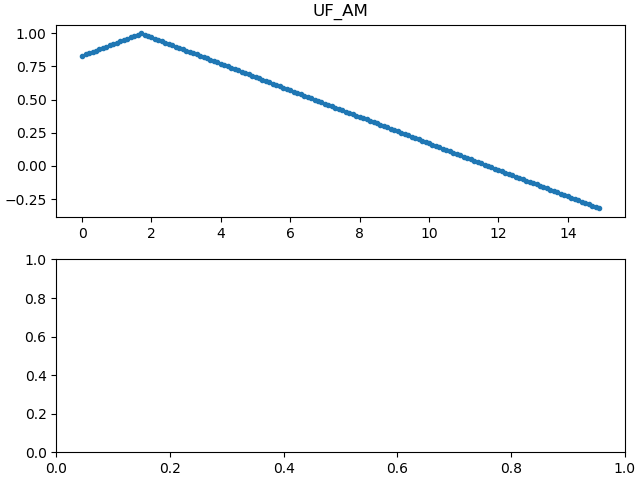

Text(0.5, 1.0, 'UF_AM')

In [87]:
# uf_global (uf_am, uf_temp_air)

am_range = pd.Series(np.arange(start=0, stop=15, step=0.1))
temp_air_range = pd.Series(np.arange(start=0, stop=70, step=0.1))

fig, axs = plt.subplots(nrows=2, ncols=1, constrained_layout=True)

axs[0].plot(am_range, cpv_sys.get_am_util_factor(am_range), '.')
axs[0].set_title('UF_AM')
#axs[1].plot(temp_air_range, cpv_sys.get_tempair_util_factor(temp_air_range), '.')
#axs[1].set_title('UF_Temp_air')
# axs[2].plot(temp_air_range, cpv_sys.get_global_utilization_factor(am_range, temp_air_range), '.')plt.show()

In [88]:
data['am'] = location.get_airmass(data.index).airmass_absolute

uf_cpv = cpv_sys.get_am_util_factor(data['am'])

p_mp_uf = power['p_mp'] * uf_cpv

Yr = irradiance.resample('M').sum() / 1000
Ya = p_mp_uf.resample('M').sum() / Pdc_stc
Lc = Yr - Ya

PR = Ya / Yr

<IPython.core.display.Javascript object>


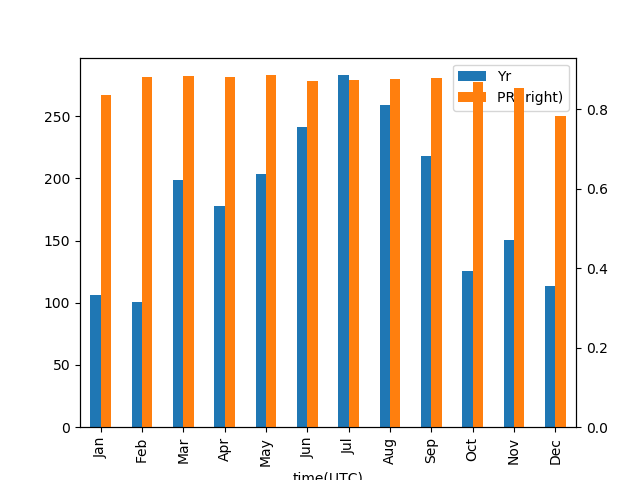

PR=0.87, Ya=1892 kWh/kW, Yr=2176 kWh/kW
Total annual energy per reference area=6592 kWh/year


In [89]:
data_monthly = pd.concat([Yr, PR], axis='columns')
data_monthly.columns = ['Yr', 'PR']

ax = data_monthly.plot(kind='bar', secondary_y='PR')
ax.set_xticklabels(data.resample('M').sum().index.strftime('%b'))

print(f'PR={Ya.sum()/Yr.sum():.2}, Ya={Ya.sum():.0f} kWh/kW, Yr={Yr.sum():.0f} kWh/kW')
print(f'Total annual energy per reference area={p_mp_uf.sum()/1000:.0f} kWh/year')